This script does the particle tracking of the movie "Swarms" which is located on 
* [\\\\MAGNETIC\Antonio\RotatingMill\Swarms.avi](\\\\MAGNETIC\Antonio\RotatingMill\Swarms.avi)

In [1]:
import trackpy as tp
import numpy as np
import scipy as sp
import pims as pm
import pandas as pd
import matplotlib as mtp
import matplotlib.pyplot as plt
import h5py as h5
import os
import copy

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as wd
from IPython.display import display
import cv2 as cv

from pims import pipeline
%matplotlib inline

@pipeline
def as_gray(frame):
    red = frame[:, :, 0]
    green = frame[:, :, 1]
    blue = frame[:, :, 2]
    return 0.2125 * red + 0.7154 * green + 0.0721 * blue

In [2]:
VideoPath = "C:\\Users\\aortiza\\Desktop\\Swarms.avi"
frames = pm.Video(VideoPath)
NumberOfFrames=int((frames.duration)*frames.frame_rate-1)

deprecated pixel format used, make sure you did set range correctly


In [3]:
w = wd.IntSlider(
    value=0,
    min=0,
    max=NumberOfFrames,
    step=1,
    continuous_update=False)

display(w)

IntSlider(value=0, continuous_update=False, max=1817)

# Get contrast adjustment parameters

In [4]:
def DynamicRangeCurve(Br,Cn):
    """ This function returns a mapping to be applied to an image to enhance contrast and brightness """
    Vin = np.arange(0,255)    
    if Cn==0:
        Cn=1e-10
    Vout = (Vin-Br*255)/Cn+127.5
    Vout[Vout>=255]=255
    Vout[Vout<0]=0
    
    return Vout, Vin

def DynamicRangeProcess(Image,Br,Cn):
    Image = (Image-Br*255)/Cn+127.5
    Image[Image>255]=255
    Image[Image<0]=0
    return Image

BrSlider = wd.FloatSlider(value=0.25,min=0,max=1,step=0.05,continuous_update=False)
CnSlider = wd.FloatSlider(value=0.2,min=0,max=2,step=0.05,continuous_update=False)
@interact(
    i = wd.IntSlider(value=0,min=0,max=NumberOfFrames,step=1,continuous_update=False),
    Br = BrSlider,
    Cn = CnSlider)
def Curve(Br,Cn,i):
    plt.figure(figsize=(10,10))
    
    ax1 = plt.subplot2grid((7,1),(0,0))
    ax3 = plt.subplot2grid((7,1),(1,0),rowspan=6)
    
    hist = cv.calcHist([frames[i]],[0],None,[256],[0,256])

    Vout, Vin = DynamicRangeCurve(Br,Cn)
    Image = DynamicRangeProcess(as_gray(frames[i]),Br,Cn)
    
    ax1.plot(Vin,Vout);
    ax1.set_xlim([0,255])
    ax1.set_ylim([0,255])
    
    ax2 = ax1.twinx()
    ax2.bar(np.arange(0,256),hist[:,0]);
    ax3.imshow(Image,cmap='gray');


interactive(children=(FloatSlider(value=0.25, continuous_update=False, description='Br', max=1.0, step=0.05), FloatSlider(value=0.2, continuous_update=False, description='Cn', max=2.0, step=0.05), IntSlider(value=0, continuous_update=False, description='i', max=1817), Output()), _dom_classes=('widget-interact',))

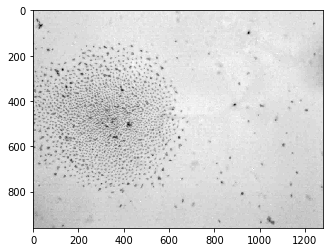

In [5]:
@pipeline
def EnhanceContrast(frame):
    return DynamicRangeProcess(frame,BrSlider.value,CnSlider.value)

plt.imshow(EnhanceContrast(as_gray(frames[1])),cmap='gray')

# Get localization parameters

In [6]:
SizeSlider = wd.IntSlider(value=5,min=1,max=51,step=2,continuous_update=False)
ThreSlider = wd.IntSlider(value=5,min=0,max=255,step=1,continuous_update=False)
w = wd.IntSlider(
    value=0,
    min=0,
    max=NumberOfFrames,
    step=1,
    continuous_update=False)

f = tp.locate(EnhanceContrast(as_gray(frames[0])), 11, invert=True)
@interact(
    i = w,
    Sz = SizeSlider,
    Tr = ThreSlider)
def SingleFrameFind(i,Sz,Tr):
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    f = tp.locate(EnhanceContrast(as_gray(frames[i])), Sz, invert=True,threshold=Tr)
    ax.imshow(EnhanceContrast(as_gray(frames[i])),cmap='gray');
    ax.plot(f.x,f.y,'o',fillstyle='none')

interactive(children=(IntSlider(value=0, continuous_update=False, description='i', max=1817), IntSlider(value=11, continuous_update=False, description='Sz', max=51, min=1, step=2), IntSlider(value=0, continuous_update=False, description='Tr', max=255), Output()), _dom_classes=('widget-interact',))

# Batch Processing

In [9]:
f = tp.batch(EnhanceContrast(as_gray(frames[:])), SizeSlider.value, invert=True,threshold=ThreSlider.value);

Frame 1817: 2455 features


# Predictive Tracking

In [12]:
import trackpy.predict as tpred

pred = tpred.NearestVelocityPredict()

Trayectories = pred.link_df(f, 5)

Frame 1817: 2455 trajectories present


### Define a saving function for trayectories

Careful: it's not very fast

In [14]:
def ScaleAndSaveTray(T,Name):
    T_output = T.filter(['x','y','particle'])

    fps = 1
    px_size = 1/3

    T_output['t'] = T_output.index/fps
    T_output['x'] = T_output.x*px_size
    T_output['y'] = T_output.y*px_size

    for i,p in enumerate(T_output.particle.unique()):
        T_output.loc[T_output.particle==p,'particle']=i
        
    T_output.to_csv(Name,
                        sep='\t',header=True,index=True, columns = ["t","x","y","particle"],float_format="%8.11g")

#ScaleAndSaveTray(Trayectories,'\\\\MAGNETIC\Antonio\RotatingMill\Swarms.dat')

### Filter stubs

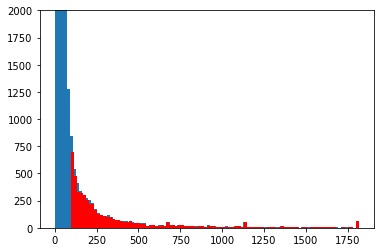

In [182]:
T_filtered = Trayectories
plt.hist(Trayectories.groupby('particle').size(),bins=100)
T_filtered = tp.filter_stubs(T_filtered, 100)
plt.hist(T_filtered.groupby('particle').size(),bins=100,color='red')
plt.ylim(0,2000);

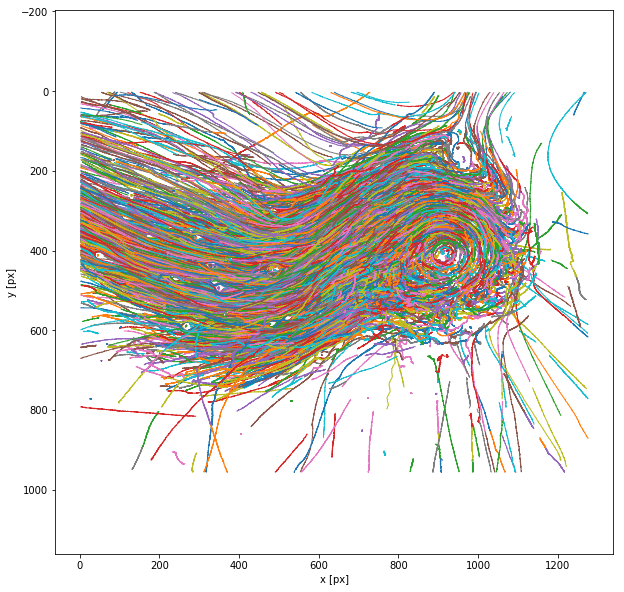

In [361]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.axis('equal')
tp.plot_traj(T_filtered);

In [21]:
ScaleAndSaveTray(T_filtered,'\\\\MAGNETIC\Antonio\RotatingMill\Swarms.dat')

### Further filter out velocities 

In [23]:
def CalculateVelocity(T):
    for i in T.particle.unique():
        location = T.particle==i
        T.loc[location,'vx'] = np.append(np.diff(T[location].x),np.NaN)
        T.loc[location,'vy'] = np.append(np.diff(T[location].y),np.NaN)
    return T

%time T_Velocities = CalculateVelocity(T_filtered)

Wall time: 3min 33s


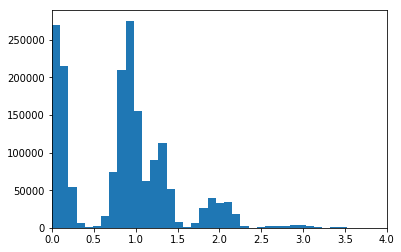

In [63]:
Discriminate = ~np.isnan(T_Velocities.vx) & ~np.isnan(T_Velocities.vy)
plt.hist(np.sqrt(T_Velocities[Discriminate].vx**2+T_Velocities[Discriminate].vy**2),bins=100);
plt.xlim(0,4);

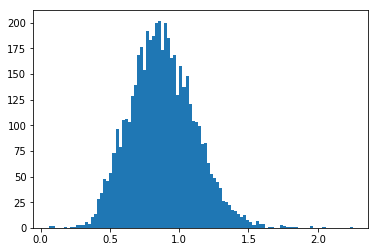

In [73]:
T_Velocities['v'] = np.sqrt(T_Velocities.vx**2+T_Velocities.vy**2)
plt.hist(T_Velocities.groupby('particle').mean().v,bins=100);

It looks like velocities don't really need further filtering

# Check Trayectories - Look for the center

In [362]:
w = wd.IntSlider(
    value=0,
    min=0,
    max=NumberOfFrames,
    step=1,
    continuous_update=False)

P = wd.Dropdown(options=T_Velocities.particle.unique(),description="particle")

@interact(i = w,p = P)
def ShowTrayectory(i,p):
    prt_loc = T_Velocities.particle==p
    frm_loc = T_Velocities.frame<i
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    ax.imshow(EnhanceContrast(as_gray(frames[i])),cmap='gray');
    ax.plot(T_Velocities[prt_loc&frm_loc].x,T_Velocities[prt_loc&frm_loc].y)
    if not np.any((T_Velocities.frame==i) & (prt_loc)):
        frm_last = T_Velocities.frame[frm_loc & prt_loc].max()
        ax.plot(
            T_Velocities[prt_loc&(T_Velocities.frame==frm_last)].x,
            T_Velocities[prt_loc&(T_Velocities.frame==frm_last)].y,'x',color='red')
    

interactive(children=(IntSlider(value=0, continuous_update=False, description='i', max=1817), Dropdown(description='particle', options=(2.0, 7.0, 8.0, 9.0, 10.0, 12.0, 14.0, 20.0, 21.0, 28.0, 29.0, 30.0, 37.0, 40.0, 43.0, 44.0, 46.0, 47.0, 48.0, 55.0, 56.0, 57.0, 58.0, 61.0, 66.0, 67.0, 76.0, 81.0, 82.0, 84.0, 87.0, 88.0, 89.0, 93.0, 94.0, 98.0, 100.0, 106.0, 107.0, 109.0, 111.0, 112.0, 119.0, 120.0, 125.0, 126.0, 133.0, 135.0, 136.0, 137.0, 139.0, 145.0, 146.0, 150.0, 153.0, 154.0, 156.0, 158.0, 163.0, 166.0, 167.0, 169.0, 171.0, 173.0, 174.0, 176.0, 177.0, 180.0, 183.0, 187.0, 193.0, 195.0, 196.0, 203.0, 204.0, 205.0, 207.0, 210.0, 212.0, 213.0, 214.0, 216.0, 218.0, 221.0, 223.0, 224.0, 225.0, 226.0, 229.0, 231.0, 232.0, 233.0, 234.0, 235.0, 237.0, 238.0, 241.0, 242.0, 243.0, 247.0, 248.0, 249.0, 250.0, 252.0, 253.0, 254.0, 256.0, 257.0, 258.0, 259.0, 260.0, 261.0, 262.0, 264.0, 266.0, 274.0, 275.0, 278.0, 279.0, 280.0, 285.0, 287.0, 291.0, 295.0, 297.0, 301.0, 308.0, 309.0, 311.0, 312.0, 313.0, 314.0, 315.0, 316.0, 317.0, 321.0, 324.0, 325.0, 326.0, 330.0, 332.0, 334.0, 338.0, 341.0, 351.0, 352.0, 353.0, 354.0, 357.0, 359.0, 361.0, 362.0, 365.0, 366.0, 367.0, 370.0, 371.0, 372.0, 373.0, 375.0, 376.0, 378.0, 381.0, 383.0, 386.0, 390.0, 391.0, 392.0, 394.0, 395.0, 398.0, 399.0, 403.0, 410.0, 411.0, 412.0, 414.0, 417.0, 419.0, 421.0, 424.0, 425.0, 427.0, 429.0, 432.0, 433.0, 434.0, 435.0, 443.0, 444.0, 447.0, 450.0, 451.0, 452.0, 455.0, 456.0, 458.0, 459.0, 460.0, 461.0, 462.0, 464.0, 467.0, 468.0, 472.0, 473.0, 474.0, 477.0, 478.0, 481.0, 482.0, 483.0, 486.0, 488.0, 489.0, 495.0, 496.0, 498.0, 499.0, 500.0, 505.0, 508.0, 509.0, 510.0, 515.0, 518.0, 520.0, 523.0, 524.0, 527.0, 529.0, 531.0, 532.0, 533.0, 536.0, 537.0, 539.0, 541.0, 547.0, 548.0, 551.0, 558.0, 559.0, 561.0, 562.0, 563.0, 565.0, 568.0, 575.0, 576.0, 577.0, 578.0, 585.0, 595.0, 596.0, 602.0, 608.0, 610.0, 618.0, 621.0, 622.0, 629.0, 632.0, 634.0, 639.0, 640.0, 641.0, 646.0, 652.0, 665.0, 669.0, 670.0, 671.0, 672.0, 673.0, 676.0, 677.0, 678.0, 680.0, 689.0, 690.0, 695.0, 696.0, 702.0, 705.0, 706.0, 708.0, 711.0, 722.0, 725.0, 734.0, 737.0, 740.0, 743.0, 748.0, 751.0, 753.0, 757.0, 764.0, 784.0, 786.0, 792.0, 794.0, 798.0, 800.0, 805.0, 808.0, 814.0, 815.0, 820.0, 829.0, 835.0, 847.0, 862.0, 867.0, 869.0, 870.0, 879.0, 880.0, 883.0, 888.0, 890.0, 894.0, 898.0, 902.0, 904.0, 908.0, 918.0, 919.0, 923.0, 929.0, 931.0, 940.0, 944.0, 948.0, 949.0, 953.0, 959.0, 965.0, 967.0, 968.0, 971.0, 972.0, 973.0, 978.0, 979.0, 981.0, 982.0, 990.0, 996.0, 1010.0, 1013.0, 1017.0, 1021.0, 1022.0, 1024.0, 1028.0, 1032.0, 1033.0, 1045.0, 1053.0, 1058.0, 1059.0, 1060.0, 1062.0, 1065.0, 1066.0, 1068.0, 1070.0, 1071.0, 1072.0, 1073.0, 1081.0, 1088.0, 1093.0, 1096.0, 1098.0, 1099.0, 1100.0, 1107.0, 1108.0, 1110.0, 1115.0, 1116.0, 1118.0, 1119.0, 1121.0, 1128.0, 1131.0, 1132.0, 1133.0, 1143.0, 1153.0, 1155.0, 1157.0, 1160.0, 1161.0, 1164.0, 1165.0, 1166.0, 1167.0, 1173.0, 1174.0, 1175.0, 1176.0, 1182.0, 1185.0, 1196.0, 1199.0, 1201.0, 1202.0, 1204.0, 1206.0, 1207.0, 1211.0, 1215.0, 1216.0, 1217.0, 1221.0, 1222.0, 1225.0, 1227.0, 1236.0, 1237.0, 1238.0, 1240.0, 1241.0, 1242.0, 1251.0, 1257.0, 1260.0, 1262.0, 1269.0, 1270.0, 1271.0, 1275.0, 1279.0, 1281.0, 1284.0, 1287.0, 1291.0, 1292.0, 1298.0, 1299.0, 1300.0, 1304.0, 1305.0, 1307.0, 1309.0, 1315.0, 1323.0, 1327.0, 1329.0, 1335.0, 1340.0, 1348.0, 1351.0, 1356.0, 1357.0, 1360.0, 1364.0, 1365.0, 1366.0, 1367.0, 1368.0, 1371.0, 1372.0, 1374.0, 1377.0, 1380.0, 1382.0, 1386.0, 1388.0, 1393.0, 1395.0, 1396.0, 1402.0, 1403.0, 1404.0, 1405.0, 1409.0, 1412.0, 1413.0, 1414.0, 1416.0, 1420.0, 1422.0, 1426.0, 1427.0, 1429.0, 1431.0, 1433.0, 1437.0, 1438.0, 1439.0, 1440.0, 1442.0, 1443.0, 1444.0, 1445.0, 1446.0, 1448.0, 1450.0, 1454.0, 1455.0, 1458.0, 1460.0, 1461.0, 1465.0, 1466.0, 1467.0, 1468.0, 1469.0, 1472.0, 1478.0, 1481.0, 1483.0, 1485.0, 1487.0, 1488.0, 1490.0, 1494.0, 1495.0, 1498.0, 1499.0, 1500.0, 1505.0, 1512.0, 1513.0, 1514.0, 1517.0, 1519.0

## Get new tracking specifically for the center. 

In [218]:
SizeSlider = wd.IntSlider(value=13,min=1,max=50,step=2,continuous_update=False)
ThreSlider = wd.IntSlider(value=24,min=0,max=50,step=1,continuous_update=False)
w = wd.IntSlider(
    value=0,
    min=0,
    max=NumberOfFrames,
    step=1,
    continuous_update=False)

c = tp.locate(EnhanceContrast(as_gray(frames[0])), 11, invert=True)
@interact(
    i = w,
    Sz = SizeSlider,
    Tr = ThreSlider)
def SingleFrameFind(i,Sz,Tr):
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    c = tp.locate(EnhanceContrast(as_gray(frames[i])), Sz, invert=True,threshold=Tr)
    ax.imshow(EnhanceContrast(as_gray(frames[i])),cmap='gray');
    ax.plot(c.x,c.y,'o',fillstyle='none')

interactive(children=(IntSlider(value=0, continuous_update=False, description='i', max=1817), IntSlider(value=13, continuous_update=False, description='Sz', max=50, min=1, step=2), IntSlider(value=24, continuous_update=False, description='Tr', max=50), Output()), _dom_classes=('widget-interact',))

In [219]:
center = tp.batch(EnhanceContrast(as_gray(frames[:])),
                  SizeSlider.value, invert=True,threshold=ThreSlider.value,
                 engine='numba');

Frame 1817: 679 features


In [245]:
pred = tpred.NearestVelocityPredict()

T_Center_Candidates = pred.link_df(center, 5, memory=3)

T_Center_Candidates.to_csv('\\\\MAGNETIC\Antonio\RotatingMill\Swarms_Center.dat',
                sep='\t',header=True,index=True, columns = ["x","y","particle"],float_format="%8.11g")

Frame 1817: 679 trajectories present


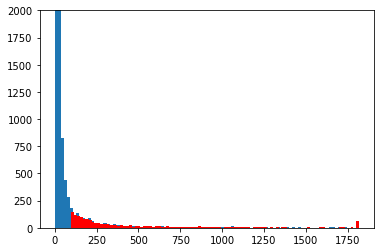

In [243]:
T_Center_Candidates_Filtered = T_Center_Candidates
plt.hist(T_Center_Candidates_Filtered.groupby('particle').size(),bins=100)
T_Center_Candidates_Filtered = tp.filter_stubs(T_Center_Candidates_Filtered, 100)
plt.hist(T_Center_Candidates_Filtered.groupby('particle').size(),bins=100,color='red')
plt.ylim(0,2000);

In [244]:
w = wd.IntSlider(
    value=1000,
    min=0,
    max=NumberOfFrames,
    step=1,
    continuous_update=False)

P = wd.Dropdown(options=T_Center_Candidates_Filtered.particle.unique(),value=267,description="particle")

@interact(i = w,p = P)
def ShowTrayectory(i,p):
    T = T_Center_Candidates_Filtered
    prt_loc = T.particle==p
    frm_loc = T.frame<i
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    ax.imshow(EnhanceContrast(as_gray(frames[i])),cmap='gray');
    ax.plot(T[prt_loc&frm_loc].x,T[prt_loc&frm_loc].y)
    if not np.any((T.frame==i) & (prt_loc)):
        frm_last = T.frame[frm_loc & prt_loc].max()
        ax.plot(
            T[prt_loc&(T.frame==frm_last)].x,
            T[prt_loc&(T.frame==frm_last)].y,'x',color='red')

interactive(children=(IntSlider(value=1000, continuous_update=False, description='i', max=1817), Dropdown(description='particle', index=149, options=(1.0, 2.0, 4.0, 5.0, 6.0, 7.0, 9.0, 10.0, 11.0, 13.0, 14.0, 16.0, 17.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 30.0, 32.0, 33.0, 35.0, 36.0, 38.0, 39.0, 40.0, 41.0, 42.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 70.0, 71.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 87.0, 88.0, 89.0, 90.0, 91.0, 96.0, 97.0, 98.0, 99.0, 101.0, 102.0, 105.0, 106.0, 109.0, 110.0, 112.0, 113.0, 114.0, 117.0, 118.0, 120.0, 122.0, 125.0, 126.0, 131.0, 133.0, 134.0, 135.0, 136.0, 138.0, 140.0, 144.0, 147.0, 148.0, 149.0, 151.0, 153.0, 154.0, 158.0, 160.0, 161.0, 164.0, 166.0, 170.0, 176.0, 177.0, 178.0, 181.0, 185.0, 186.0, 188.0, 191.0, 194.0, 197.0, 199.0, 202.0, 203.0, 204.0, 205.0, 206.0, 207.0, 208.0, 215.0, 216.0, 217.0, 218.0, 220.0, 222.0, 225.0, 228.0, 230.0, 231.0, 237.0, 238.0, 239.0, 241.0, 242.0, 250.0, 252.0, 256.0, 257.0, 259.0, 261.0, 267.0, 272.0, 280.0, 286.0, 288.0, 291.0, 293.0, 294.0, 296.0, 304.0, 305.0, 310.0, 314.0, 320.0, 321.0, 324.0, 328.0, 330.0, 332.0, 336.0, 342.0, 344.0, 348.0, 349.0, 350.0, 352.0, 354.0, 355.0, 357.0, 360.0, 363.0, 366.0, 368.0, 371.0, 372.0, 374.0, 375.0, 377.0, 378.0, 382.0, 384.0, 386.0, 388.0, 391.0, 393.0, 400.0, 401.0, 403.0, 404.0, 409.0, 410.0, 411.0, 415.0, 416.0, 417.0, 418.0, 424.0, 428.0, 431.0, 432.0, 433.0, 434.0, 435.0, 438.0, 441.0, 443.0, 444.0, 446.0, 448.0, 450.0, 451.0, 452.0, 453.0, 454.0, 458.0, 461.0, 462.0, 466.0, 473.0, 474.0, 475.0, 477.0, 482.0, 485.0, 486.0, 490.0, 493.0, 494.0, 498.0, 499.0, 500.0, 501.0, 504.0, 505.0, 507.0, 508.0, 514.0, 516.0, 519.0, 523.0, 528.0, 529.0, 531.0, 533.0, 534.0, 535.0, 537.0, 542.0, 546.0, 549.0, 550.0, 553.0, 555.0, 557.0, 559.0, 560.0, 563.0, 564.0, 565.0, 566.0, 569.0, 571.0, 576.0, 578.0, 579.0, 581.0, 584.0, 585.0, 587.0, 589.0, 590.0, 591.0, 592.0, 593.0, 595.0, 598.0, 599.0, 600.0, 601.0, 602.0, 603.0, 604.0, 606.0, 608.0, 609.0, 610.0, 611.0, 612.0, 613.0, 614.0, 615.0, 617.0, 618.0, 619.0, 620.0, 661.0, 699.0, 727.0, 729.0, 828.0, 863.0, 887.0, 1002.0, 1093.0, 1468.0, 1564.0, 1573.0, 1581.0, 1620.0, 1685.0, 1847.0, 1883.0, 2002.0, 2009.0, 2163.0, 2493.0, 2713.0, 2764.0, 2943.0, 3173.0, 3177.0, 3214.0, 3228.0, 3250.0, 3610.0, 3624.0, 3791.0, 3846.0, 4007.0, 4017.0, 4212.0, 4374.0, 4400.0, 4522.0, 4634.0, 4692.0, 4802.0, 4989.0, 5070.0, 5142.0, 5230.0, 5602.0, 5626.0, 5656.0, 5736.0, 5767.0, 5834.0, 5859.0, 6187.0, 6227.0, 6242.0, 6323.0, 6612.0, 6684.0, 6847.0, 6968.0, 7200.0, 7255.0, 7558.0, 7592.0, 7781.0, 7799.0, 7803.0, 7932.0, 7990.0, 8069.0, 8150.0, 8172.0, 8380.0, 8389.0, 8537.0, 8626.0, 8678.0, 8735.0, 8840.0, 8856.0, 8874.0, 9061.0, 9167.0, 9309.0, 9323.0, 9413.0, 9517.0, 9666.0, 9782.0, 9806.0, 9808.0, 9898.0, 9961.0, 10057.0, 10063.0, 10103.0, 10393.0, 10473.0, 10520.0, 10683.0, 10943.0, 10987.0, 10997.0, 11009.0, 11161.0, 11457.0, 11478.0, 11719.0, 11835.0, 11914.0, 11928.0, 11988.0, 12031.0, 12157.0, 12250.0, 12294.0, 12461.0, 12509.0, 12646.0, 12856.0, 12857.0, 12925.0, 13182.0, 13304.0, 13323.0, 13334.0, 13359.0, 13458.0, 13583.0, 13726.0, 13820.0, 13830.0, 13926.0, 13954.0, 14013.0, 14070.0, 14071.0, 14101.0, 14290.0, 14378.0, 14425.0, 14519.0, 14566.0, 14683.0, 14759.0, 15032.0, 15041.0, 15055.0, 15334.0, 15544.0, 15557.0, 15670.0, 15676.0, 15681.0, 15688.0, 15742.0, 16275.0, 16345.0, 16356.0, 16590.0, 16599.0, 16608.0, 16677.0, 16679.0, 16817.0, 17273.0, 17281.0, 17303.0, 17430.0, 17551.0, 17553.0, 17636.0, 17649.0, 17676.0, 17778.0, 17790.0, 17897.0, 17898.0, 17923.0, 18166.0, 18338.0, 18350.0, 18423.0, 18466.0, 18743.0, 18791.0, 18870.0, 18907.0, 18937.0, 19040.0, 19134.0, 19179.0, 19340.0, 19548.0, 19792.0, 19906.0, 20223.0, 20515.0, 20520.0, 20540.0, 20545.0, 20727.0, 20738.0, 21087.0, 21090.0, 21261.0, 21316.0, 21451.0, 21616.0, 21699.0, 21763.

In [241]:
def GetNextParticle(IncompleteParticle):
    T = T_Center_Candidates_Filtered

    Incomplete1 = T[T.particle==IncompleteParticle]

    x = Incomplete1.mean().y
    y = Incomplete1.mean().y

    Tol = 50
    WithinTol = np.sqrt((T.x-x)**2+(T.y-y)**2)<Tol/2
    NonOverlap = ~T.frame.isin(Incomplete1.frame)

    return T[WithinTol & NonOverlap].particle
    
GetNextParticle(267)

frame
379      26843.0
380      26843.0
381      26843.0
382      26843.0
383      26843.0
384      26843.0
385      26843.0
386      26843.0
387      26843.0
388      26843.0
389      26843.0
390      26843.0
391      26843.0
392      26843.0
393      26843.0
394      26843.0
395      26843.0
396      26843.0
397      26843.0
397      31924.0
398      26843.0
398      31924.0
399      26843.0
399      31924.0
400      26843.0
400      31924.0
401      26843.0
401      31924.0
402      26843.0
402      31924.0
          ...   
1777    121270.0
1778    121270.0
1779    121270.0
1780    121270.0
1781    121270.0
1782    121270.0
1783    121270.0
1784    121270.0
1785    121270.0
1786    121270.0
1787    121270.0
1788    121270.0
1789    121270.0
1790    121270.0
1791    121270.0
1792    121270.0
1793    121270.0
1794    121270.0
1795    121270.0
1796    121270.0
1797    121270.0
1798    121270.0
1799    121270.0
1800    121270.0
1801    121270.0
1802    121270.0
1803    121270.0
1804    

## Use manual tracking

In [272]:
center_man = pd.read_csv('\\\\MAGNETIC\Antonio\RotatingMill\Swarms_Center_Manual.csv',
                        sep=',',header=0,index_col=0, encoding = "ISO-8859-1")
center_man.head()

,Track n°,Slice n°,X,Y,Distance,Velocity,Pixel Value
,,,,,,,
1,1,1,891,418,-1.000,-1.000,-13684945
2,1,2,891,415,0.387,0.194,-14342875
3,1,3,891,415,0.000,0.000,-14474461
4,1,4,889,416,0.288,0.144,-14145496
5,1,5,889,418,0.258,0.129,-13619152


In [273]:
center_man.columns = ['particle','frame','x','y','d','v','px']
center_man = center_man.filter(['frame','particle','x','y'])
center_man.head()

,frame,particle,x,y
,,,,
1,1,1,891,418
2,2,1,891,415
3,3,1,891,415
4,4,1,889,416
5,5,1,889,418


In [345]:
center_out = pd.DataFrame(index=[center_man.frame.unique()-1], columns=center.columns)

for i in center_man.frame.unique():
    x = center_man[center_man.frame==i].x.values[0]
    y = center_man[center_man.frame==i].y.values[0]

    ThisFrame = np.where(center.frame==i-1)[0]
    Distance = np.sqrt((x-center.iloc[ThisFrame].x)**2+(y-center.iloc[ThisFrame].y)**2)
    
    center_out.iloc[i-1]=center.iloc[ThisFrame[Distance.values.argmin()]]


In [356]:
center_out["particle"]=0
T_Center = center_out
center_out.head()

,x,y,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,889.993,416.189,10403.9,3.66412,0.129996,176.924,-10142,0.0264836,0,0
1,889.891,416.223,9024.59,3.60059,0.119643,169.9,-12337,0.0311359,1,0
2,889.952,416.162,11520.6,3.75878,0.10202,177.262,-8525.75,0.0240488,2,0
3,890.037,416.171,10278.9,3.64269,0.116585,176.357,-10374.5,0.0272237,3,0
4,889.905,416.186,9311.79,3.5987,0.142024,170.059,-12000.8,0.0303155,4,0


In [349]:
w = wd.IntSlider(
    value=1000,
    min=0,
    max=NumberOfFrames,
    step=1,
    continuous_update=False)

@interact(i = w)
def ShowTrayectory(i):
    T = T_Center
    frm_loc = T.frame<i
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    ax.imshow(EnhanceContrast(as_gray(frames[i])),cmap='gray');
    ax.plot(T[frm_loc].x,T[frm_loc].y)

interactive(children=(IntSlider(value=1000, continuous_update=False, description='i', max=1817), Output()), _dom_classes=('widget-interact',))

In [358]:
ScaleAndSaveTray(T_Center.set_index('frame'),'\\\\MAGNETIC\Antonio\RotatingMill\Swarms_Center.dat')